In [ ]:
%tensorflow_version 2.x

In [41]:
!pip install scikit-learn==0.23.2

     |████████████████████████████████| 6.8MB 17.1MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [1]:
import sklearn
print(sklearn.__version__)

0.23.2


In [2]:
import tensorflow
print(tensorflow.__version__)

2.4.0


In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# %load_ext nb_black
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
DATA_PATH = Path("/content/drive/MyDrive/Geostorm Competition Data")

In [6]:
dst = pd.read_csv(DATA_PATH / "dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

In [7]:
sunspots = pd.read_csv(DATA_PATH / "sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

In [8]:
solar_wind = pd.read_csv(DATA_PATH / "solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

In [9]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(2020)
set_seed(2021)

In [10]:
from sklearn.preprocessing import StandardScaler

# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)

def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df

def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and std
    e.g. All values from "11:00:00" to "11:59:00" will be aggregate to "11:00:00"
    """
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierarchical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged

def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate Hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]
        
    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)
    
    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)
    
    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )
    
    # impute missing values
    imputed = impute_features(normalized)
    
    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [11]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(139872, 15)


bt_mean    bt_std  ...  density_std  smoothed_ssn
period  timedelta                            ...                           
train_a 0 days 00:00:00  0.499705  2.443614  ...    -0.205724      0.139444
        0 days 01:00:00  0.547177 -0.224580  ...    -0.058215      0.139444
        0 days 02:00:00  0.739905 -0.770240  ...    -0.220012      0.139444
        0 days 03:00:00  0.699098 -0.278783  ...     0.218373      0.139444
        0 days 04:00:00  0.223933 -0.225168  ...     0.097253      0.139444

[5 rows x 15 columns]

In [14]:
# check to make sure missing values are filled
assert (features.isna().sum() == 0).all()

In [15]:
YCOLS = ["t0", "t1"]

def process_labels(dst):
    y = dst.copy()
    y["t1"] = y.groupby("period").dst.shift(-1)
    y.columns = YCOLS
    return y

labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                
train_a 0 days 00:00:00  -7 -10.0
        0 days 01:00:00 -10 -10.0
        0 days 02:00:00 -10  -6.0
        0 days 03:00:00  -6  -2.0
        0 days 04:00:00  -2   3.0

In [16]:
data = labels.join(features)
data.head()

t0    t1  ...  density_std  smoothed_ssn
period  timedelta                  ...                           
train_a 0 days 00:00:00  -7 -10.0  ...    -0.205724      0.139444
        0 days 01:00:00 -10 -10.0  ...    -0.058215      0.139444
        0 days 02:00:00 -10  -6.0  ...    -0.220012      0.139444
        0 days 03:00:00  -6  -2.0  ...     0.218373      0.139444
        0 days 04:00:00  -2   3.0  ...     0.097253      0.139444

[5 rows x 17 columns]

In [17]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation """
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = interim.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val

train, test, val = get_train_test_val(data, test_per_period=6000, val_per_period=3000)

In [19]:
from tensorflow.keras import preprocessing

data_config = {
    "timesteps": 32,
    "batch_size": 32,
}

def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]
    
    # iterate through the periods
    for _, period_df in df.groupby("period"):
        # realign features and lables so that the first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]
        
        period_ds = preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size
        )
        
        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)
            
    return dataset

train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of validation batches: {len(val_ds)}")

Number of train batches: 3523
Number of validation batches: 276


In [20]:
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

# define our model
model_config = {
    "n_epochs": 20,
    "n_neurons": 512,
    "dropout": 0.4,
    "stateful": False
}

model = Sequential()
model.add(
    LSTM(
        model_config["n_neurons"],
        # batch input shape usually set to (`batch_size`, `sequence_length`, `n_features`)
        # setting the batch size to None allows for variable length batches
        batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
        stateful=model_config["stateful"],
        dropout=model_config["dropout"],
    )
)
model.add(Dense(len(YCOLS)))
model.compile(
    loss="mean_squared_error",
    optimizer="adam",)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1081344   
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 1,082,370
Trainable params: 1,082,370
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=1,
    shuffle=False,
    validation_data=val_ds
)

Epoch 1/20
3523/3523 [==============================] - 39s 9ms/step - loss: 434.1621 - val_loss: 607.5424
Epoch 2/20
3523/3523 [==============================] - 32s 9ms/step - loss: 425.1254 - val_loss: 471.6572
Epoch 3/20
3523/3523 [==============================] - 31s 9ms/step - loss: 337.6516 - val_loss: 377.7849
Epoch 4/20
3523/3523 [==============================] - 31s 9ms/step - loss: 278.8641 - val_loss: 321.0105
Epoch 5/20
3523/3523 [==============================] - 32s 9ms/step - loss: 239.6837 - val_loss: 278.6241
Epoch 6/20
3523/3523 [==============================] - 32s 9ms/step - loss: 221.6318 - val_loss: 245.7606
Epoch 7/20
3523/3523 [==============================] - 32s 9ms/step - loss: 211.2616 - val_loss: 222.8792
Epoch 8/20
3523/3523 [==============================] - 32s 9ms/step - loss: 198.2780 - val_loss: 216.0772
Epoch 9/20
3523/3523 [==============================] - 32s 9ms/step - loss: 191.7375 - val_loss: 210.7024
Epoch 10/20
3523/3523 [==============

# Evaluation

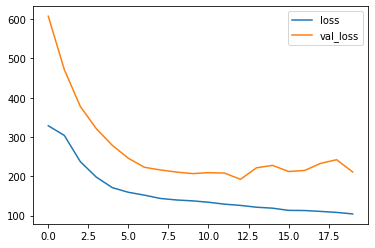

In [26]:
for name, values in history.history.items():
  plt.plot(values, label=name)
plt.legend()
plt.show()

In [27]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])

In [28]:
mse = model.evaluate(test_ds)
print(f"Test RMSE: {mse ** .5 :.2f}")

558/558 [==============================] - 4s 7ms/step - loss: 189.9985
Test RMSE: 13.78


## Saving the Model

In [15]:
import json
import pickle

# model.save("model.h5")

with open("scaler.pck", "wb") as f:
  pickle.dump(scaler, f)

# data_config["solar_wind_subset"] = SOLAR_WIND_FEATURES
# print(data_config)
# with open("config.json", "w") as f:
#     json.dump(data_config, f)

## Prepare Submission

In [38]:
import json
import pickle
from typing import Tuple

import pandas as pd
from tensorflow.keras.models import load_model

# load in serialized model, config, and scaler
model = load_model("model.h5")

with open("config.json", "r") as f:
    CONFIG = json.load(f)
    
with open("scaler.pck", "rb") as f:
    scaler = pickle.load(f)
    
# Set global variables
TIMESTEPS = CONFIG["timesteps"]
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]

XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)

# Define functions for preprocessing
def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(0).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler


# THIS MUST BE DEFINED FOR YOUR SUBMISSION TO RUN
def predict_dst(
    solar_wind_7d: pd.DataFrame,
    satellite_positions_7d: pd.DataFrame,
    latest_sunspot_number: float,
) -> Tuple[float, float]:
    """
    Take all of the data up until time t-1, and then make predictions for
    times t and t+1.
    Parameters
    ----------
    solar_wind_7d: pd.DataFrame
        The last 7 days of satellite data up until (t - 1) minutes [exclusive of t]
    satellite_positions_7d: pd.DataFrame
        The last 7 days of satellite position data up until the present time [inclusive of t]
    latest_sunspot_number: float
        The latest monthly sunspot number (SSN) to be available
    Returns
    -------
    predictions : Tuple[float, float]
        A tuple of two predictions, for (t and t + 1 hour) respectively; these should
        be between -2,000 and 500.
    """
    # Re-format data to fit into our pipeline
    sunspots = pd.DataFrame(index=solar_wind_7d.index, columns=["smoothed_ssn"])
    sunspots["smoothed_ssn"] = latest_sunspot_number
    
    # Process our features and grab last 32 (timesteps) hours
    features, s = preprocess_features(
        solar_wind_7d, sunspots, scaler=scaler, subset=SOLAR_WIND_FEATURES
    )
    model_input = features[-TIMESTEPS:][XCOLS].values.reshape(
        (1, TIMESTEPS, features.shape[1])
    )
    
    # Make a prediction
    prediction_at_t0, prediction_at_t1 = model.predict(model_input)[0]

    # Optional check for unexpected values
    if not np.isfinite(prediction_at_t0):
        prediction_at_t0 = -12
    if not np.isfinite(prediction_at_t1):
        prediction_at_t1 = -12

    return prediction_at_t0, prediction_at_t1

In [13]:
scaler.n_features_in_

15